# Convolution  and Correlation

---

> Samuel Farrens 2016

## Contents

---

1. [Introdution](#Introduction)
1. [Set-Up](#Set-Up)
1. [Convolution](#Convolution)
 * [Definition](#Definition)
1. [Correlation](#Correlation)

## Introduction

---

## Set-Up

---

Here we will import a couple of packages that we will need throughout the notebook.

In [393]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np               

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  

# Import the scipy packages.
import scipy.signal as signal 
import scipy.stats as stats 

## Convolution

---

> References: 
> * [Wikipedia](https://en.wikipedia.org/wiki/Convolution)
> * [1D Convolution Example](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.convolve.html)
> * [2D Convolution Example](http://www.songho.ca/dsp/convolution/convolution2d_example.html)

### Definition

Convolution is defined as the integral of the product of the two functions after one is reversed and shifted.

$$(f \ast g)(t) = \int^\infty_{-\infty} f(\tau)g(t-\tau)d\tau = \int^\infty_{-\infty} f(t-\tau)g(\tau)d\tau$$

Discrete convolution for a finite set can be respesented as follows:

$$(f \ast g)[n] = \sum^{M}_{m=-M} f[n]g[m-n] = \sum^{M}_{m=-M} f[m-n]g[n]$$

In Python we can respresent the discrete convolution with the following function:

In [394]:
# Define a function to perfom a 1D discrete convolution.
def convolve(x, y, mode='same'):
    
    x_pad = np.roll(np.hstack((x, np.zeros(2 * (y.size - 1)))), (y.size - 1))
    
    shifts = range(np.abs(x_pad.size - y.size) + 1)
                    
    full = np.sum([(np.roll(x_pad, -i)[:y.size] * y[::-1]) for i in shifts], axis=1)
    
    roll = - np.int((y.size - 1) / 2.0)
        
    if mode == 'same':
        return np.roll(full, roll)[:x.size]
    
    else:
        return full

We can demonstrate our function with a simple example where

$$ f(x) = \begin{cases} 1.0 & 100 \leq x < 200 \\ 0.0 & \text{otherwise} \end{cases} $$

and 

$$ g(x) = $$

With these two functions we can difine a new function

$$ y(x) = f(x) \ast g(x) = g(x) \ast f(x) $$

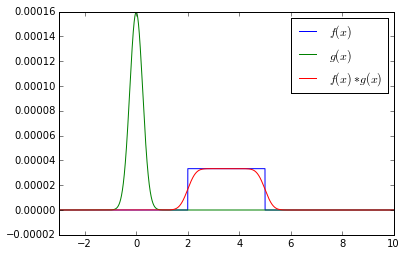

In [402]:
simple = stats.uniform(loc=2, scale=3)
err = stats.norm(loc=0, scale=0.25)

delta = 1e-4

x = np.arange(-10, 10, delta)

f = simple.pdf(x) * delta
g = err.pdf(x) * delta

y = signal.fftconvolve(f, g, 'same')
y = y / sum(y)

plt.plot(x, f, label='$f(x)$')
plt.plot(x, g, label='$g(x)$')
plt.plot(x, y, label='$f(x) * g(x)$')
plt.xlim(-3, max(x))
plt.legend()
plt.show()

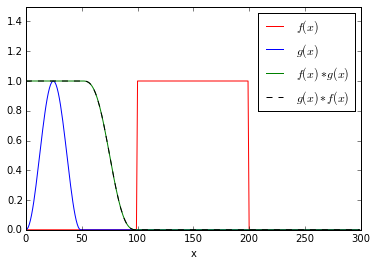

In [389]:
# Set a range of x values.
x = np.arange(300)

# Define the function f(x).
def f(x):
    
    return np.array((x >= 100) * (x < 200), dtype='int')


# Define the function g(x).
def g(x):
    
    def hann(n, m):
        
        return (0.5 - 0.5 * np.cos((2 * np.pi * n) / (m - 1)))
  
    return np.array([hann(n, 50) if (0 < n < 50) else 0.0 for n in range(x.size)])

fg = convolve(f(x), g(x), mode='same') / sum(g(x))
gf = convolve(g(x), f(x), mode='same') / sum(g(x))

# # Plot the two functions.
plt.plot(x, f(x), 'r-', label='$f(x)$')
plt.plot(x, g(x), 'b-', label='$g(x)$')
plt.plot(x, fg, 'g-', label='$f(x) * g(x)$')
plt.plot(x, gf, 'k--', label='$g(x) * f(x)$')

# plt.xlim(0.0, 2 * np.pi)
plt.ylim(0.0, 1.5)
plt.xlabel('x')
plt.legend()
plt.show()

In [376]:
A = np.arange(9).reshape(3, 3) + 1
B = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

print 'Convolve'
print convolve(A, B, mode='same')
print ''
print 'FFT Convolve'
print fftconvolve(A, B, mode='same')
print ''

Convolve


ValueError: all the input arrays must have same number of dimensions

In [3]:
def myFFTconvolve(x, y, mode='same'):
    
    # Additional zero padding for even matrices.
    x_fix, y_fix = [(1 - np.array(z.shape) % 2) for z in [x, y]]
    
    # Pixel radius for zero padding.
    x_rad, y_rad = [np.array(z.shape) / 2 for z in [x, y]]

    # Add zero padding to input matrices.
    x_pad = np.pad(x, ((y_rad[0], y_rad[0] + x_fix[0]), (y_rad[1], y_rad[1] + x_fix[1])), mode='constant')
    y_pad = np.pad(y, ((x_rad[0], x_rad[0] + y_fix[0]), (x_rad[1], x_rad[1] + y_fix[1])), mode='constant')
    
    # Calculate the full convolution of the zero padded matrices.
    full = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.fft2(x_pad) * np.fft.fft2(y_pad))))

    # Find the centre of the convoled matrix.
    centre = np.array(full.shape) / 2
    
    if mode == 'same':
    
        # Extract the central values with the same shape as the input matrix x from the colvolved matrix.
        x_sl = [slice(a - b, a + b - c + 1) for a, b, c in zip(centre, x_rad, x_fix)]

        # Return the sliced matrix.
        return full[x_sl]
    
    elif mode == 'full': 
        
        # Return the full matrix.
        return full
    
    else:
        
        raise ValueError('Invalide option for mode.')
        
        
def myFFTcorrelate(x, y, mode='same'):

    return myFFTconvolve(x, np.rot90(y, 2), mode)


def myFFTautocorrelate(x, mode='same'):
    
    return myFFTcorrelate(x, x)

In [4]:
print 'My FFT Convolve'
print myFFTconvolve(A, B)
print ''

My FFT Convolve
[[-13. -20. -17.]
 [-18. -24. -18.]
 [ 13.  20.  17.]]



In [5]:
print 'Correlate'
print correlate2d(A, B, mode='same')
print ''
print 'My Correl'
print myFFTcorrelate(A, B)
print ''

Correlate
[[ 13  20  17]
 [ 18  24  18]
 [-13 -20 -17]]

My Correl
[[ 13.  20.  17.]
 [ 18.  24.  18.]
 [-13. -20. -17.]]



In [6]:
print 'Auto-Correlate'
print correlate2d(A, A, mode='same')
print ''
print 'My Auto-Correlate'
print myFFTautocorrelate(A)
print 

Auto-Correlate
[[ 94 154 106]
 [186 285 186]
 [106 154  94]]

My Auto-Correlate
[[  94.  154.  106.]
 [ 186.  285.  186.]
 [ 106.  154.   94.]]



In [7]:
from functions.stats import autocorr2d

print autocorr2d(A)
print np.linalg.norm(np.abs(np.fft.fft2(A)) ** 2)

2054.30791266
2054.30791266
